# save data to pickle

In [33]:
# # save variables to pickle
# import pickle
# filename = "variables.pickle"
# with open(filename, 'wb') as f:
#     pickle.dump({
#         'qtw_imputed': qtw_imputed,
#         'qtw_encoded': qtw_encoded
#     }, f)

# get data from pickle

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

with open('variables.pickle', 'rb') as f:
    pic = pickle.load(f)
qtw = pic["qtw"]

# set column names

In [2]:
column_names = qtw.columns.values.tolist()
base_cols = [column_name for column_name in column_names if "M1" not in column_name and "M2" not in column_name and "M3" not in column_name and "M6" not in column_name]
m1_cols = base_cols + [column_name for column_name in column_names if "M1" in column_name]
m2_cols = m1_cols + [column_name for column_name in column_names if "M2" in column_name]
m3_cols = m2_cols + [column_name for column_name in column_names if "M3" in column_name]

# set up models

In [3]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso

# iterate over base, m1, m2, m3 cols to predict m6

In [4]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [5]:
results = {}

set_of_cols = {
    "base": base_cols,
    "m1": base_cols + m1_cols,
    "m2": base_cols + m1_cols + m2_cols,
    "m3": base_cols + m1_cols + m2_cols + m3_cols,
}
# xgboost params
param = {'max_depth': 8, 'eta': .3, 'objective': 'binary:logistic', "scale_pos_weight" : 1}
param['nthread'] = 4
param['eval_metric'] = ["aucpr"]
num_round = 10

In [6]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df


In [17]:

for name, cols in zip(list(set_of_cols.keys()), list(set_of_cols.values())):
    # X
    data = pd.DataFrame()
    
    print("-----")
    print(f"training {name} set of columns")
    for col in cols:
        data = pd.concat([data.reset_index(drop=True), qtw.filter(regex = col)], axis=1)
    # y
    label = qtw["M6_VQ_ITT"]
    label = pd.get_dummies(label, drop_first = True)
    # invert labelling to predict validated abstinence
    label = 1 - label
    
    # CV split
    rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    fold = 0
    results[name] = {}
    for train_index, test_index in rs.split(data):
        X_train = data.iloc[train_index, :]
        y_train = label.iloc[train_index, :]
        X_test = data.iloc[test_index, :]
        y_test = label.iloc[test_index, :]



        X_train = X_train.loc[:,~X_train.columns.duplicated()]
        
        # imputation of train set
        X_train = imputation(X_train,X_train.select_dtypes(include = "object").columns.values.tolist())
        # encoding
        X_train = pd.get_dummies(X_train, drop_first = True)
        X_names = X_train.columns

        X_test = X_test.loc[:,~X_test.columns.duplicated()]
        # imputation of test set
        X_test = imputation(X_test,X_test.select_dtypes(include = "object").columns.values.tolist())
        # encoding
        X_test = pd.get_dummies(X_test, drop_first = True)

#         model = EasyEnsembleClassifier(random_state = 42)
#         model = LogisticRegression(penalty = 'l1',
#                                    solver="liblinear")
#         model = RandomForestClassifier()
        model.fit(X_train, y_train)
        ypred = model.predict_proba(X_test)[:,1]
        yclass = model.predict(X_test)
        
        results[name][f"fold{fold}"] = {
            "precision": precision_score(yclass, y_test, average = "binary"),
            "recall":recall_score(yclass, y_test, average = "binary"), 
            "aucpr": precision_recall_curve(y_test, ypred),
            "model": model,
            "feature_names": X_names
        }
        fold +=1 

-----
training base set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning

-----
training m1 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pas

-----
training m2 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pas

-----
training m3 set of columns


/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was pas

In [18]:
# save variables to pickle
import pickle
filename = "./randomforest/rf_results.pickle"
with open(filename, 'wb') as f:
    pickle.dump(results, f)

In [19]:
for name in results.keys():
    folds = 0
    precision = 0
    recall = 0
    print(f"printing metrics of prediction model based on {name} set of cols")
    for fold in results[name].keys():
        folds+=1
        precision += results[name][fold]["precision"]
        recall += results[name][fold]["recall"]
    precision /= folds
    recall /= folds
    print(round(precision,3), round(recall,3))

printing metrics of prediction model based on base set of cols
0.64 0.128
printing metrics of prediction model based on m1 set of cols
0.708 0.176
printing metrics of prediction model based on m2 set of cols
0.745 0.222
printing metrics of prediction model based on m3 set of cols
0.819 0.308


# load results

In [25]:
with open('./xgboost/xgboost_results_10to1.pickle', 'rb') as f:
    results = pickle.load(f)

# PRAUC

In [26]:
import matplotlib.colors as mcolors
from sklearn.metrics import auc

recall_df = np.array([])
precision_df = np.array([])
aucpr = 0
for name in results.keys():
    fold_num = 0
    for fold in results[name].keys():
        fold_num += 1
        (precision, recall, thresholds) = results[name][fold]["aucpr"]
        aucpr += auc(recall, precision)
    aucpr /= fold_num
    print(f"{name} set of features aucpr is {round(aucpr,3)}")

base set of features aucpr is 0.155
m1 set of features aucpr is 0.309
m2 set of features aucpr is 0.416
m3 set of features aucpr is 0.52


0.42251843320270743


Text(0, 0.5, 'Precision')

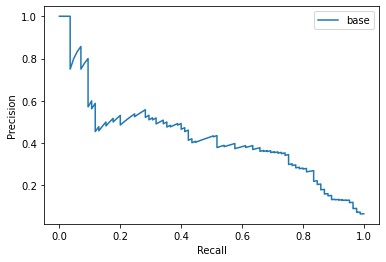

In [22]:
precision, recall, thresholds = results["m3"]["fold0"]["aucpr"]
plt.plot(recall, precision)
print(auc(recall, precision))
plt.legend(results.keys())
plt.xlabel("Recall")
plt.ylabel("Precision")
#     plt.savefig("./xgboost/aucpr.png", dpi = 200)

In [4]:
# not sure if easy ensemble has any function to output feature importance
plt.figure(figsize=(20,40))
for name in ['base', 'm1', 'm2', 'm3']:
    importance = {}
    fold_num = 0
    for importance_type in ["weight", 'gain', "cover"]:
        for fold in results[name].keys():
            # Get the importance dictionary (by gain) from the booster
            importance_holder = results[name][fold]["model"].get_score(importance_type=importance_type)
            for key, value in list(zip(importance_holder.keys(), importance_holder.values())):
                if key not in importance.keys():
                    importance[key] = 0
                importance[key] += value
#             import pdb; pdb.set_trace()
            fold_num += 1

        # round off score to 2 decimal places
        for key in importance.keys():
            importance[key] /= fold_num
            importance[key] = round(importance[key],2)
        xgb.plot_importance(importance, 
                            importance_type = importance_type, 
                            max_num_features = 10,
                            xlabel = importance_type,
                            title = f"Feature importance in terms of {importance_type}\nfor {name} set of features")
#         plt.savefig(f"./easyensemble/feature_importance_{name}_{importance_type}.png", dpi=200, bbox_inches='tight')

AttributeError: 'EasyEnsembleClassifier' object has no attribute 'get_score'

<Figure size 1440x2880 with 0 Axes>

In [40]:
importance[key]

KeyError: 'Base_CpdGp_21-30'

In [26]:
results[model][fold]["model"].get_score(importance_type=importance_type)

{'Year': 82.0,
 'Base_CO': 121.0,
 'Base_HSI': 62.0,
 'Base_Cpd': 96.0,
 'Base_Age_weekly_smoking': 154.0,
 'Base_QConfidence': 95.0,
 'Treatment': 25.0,
 'Age_5Gp_30-39': 15.0,
 'Age_5Gp_40-49': 22.0,
 'Age_5Gp_50-59': 22.0,
 'Age_5Gp_60+': 22.0,
 'Housing_Others': 5.0,
 'Housing_Private': 20.0,
 'Housing_Public': 24.0,
 'Employment_Housekeeper': 4.0,
 'Employment_Retired': 11.0,
 'Employment_Student': 9.0,
 'Employment_Unemployed': 7.0,
 'Base_CpdGp_11-20': 8.0,
 'Base_CpdGp_21-30': 6.0,
 'Base_QA_time_never tried to quit': 26.0,
 'Base_QA_time_within 6 months (but before the passing month)': 19.0,
 'Base_QA_time_within this month': 5.0,
 'Base_QA_time_within this year (but before the passing 6 months)': 4.0,
 'Base_Ready_In 60 days': 3.0,
 'Base_Ready_In 7 days': 22.0,
 'Base_Ready_Undecided/>60 days': 21.0}